# Preparation & peek at the data structure


## Loading packages

In [ ]:
import re
from pathlib import Path
import numpy as np 
import pandas as pd
import pickle

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from skimage import io

# tqdm is a library that enables you to visualize the progress of a for loop by displaying a configurable progress bar
from tqdm.notebook import tqdm
tqdm().pandas();
import cv2

print('import complete')

## Exploring the data structure
We start by exploring the file structure to gain an understanding of how everything is organised

### Navigating to Directory Containing Data Files

In [ ]:
input_path = Path.cwd()/'../input/breast-histopathology-images'
print(input_path)

Now that we have the directory containing our files, we can proceed to exploring the underlying structure.

In [ ]:
# Create List of Paths
path_contents = [path for path in Path.iterdir(input_path)]
# Print out the first 5 paths
path_contents[0:5]

We can see above that inside our breast-histopathology folder we have a folder that labeled with each patients id. <br>

### Understanding Directory Structure
Next let's see count the number of files in the path above and the number of folders so that we make sure we aren't missing anything.

So it seems that we need to drill down more to find our files, and it seems that each file contains the data for the patient with the corresponding patient id. <br>

Next, let's take a look at the contents of the first folder.

Based on the code above we can see that the first patient_folder contains 2 folders and no files.
It's best practice to validate that all the other files and folders contain the same sub-folder stucture of 2 folders and 0 files.

### Verifying Directory Structure
The funcion below accepts the path to the directory that you would like to explore and accepts the number of folders and files that you would like to verify that each path in that directory contains.<br>

It returns the dictionary containing the paths of the matched and unmatched files.

### Reaching the image file paths
Now that we know which paths match our structure criteria we will leave the other file for later, and continue exploring the matched files that we have.

Recall that, each patient directory has 2 sub-folders, labeled 0 and 1 <br/>
Folder 0: Non-Invasive Ductal Carcinoma (IDC) <br/>
Folder 1 : Invasive Ductal Carcinoma (IDC) <br/>

Let's check out the folder contents of each directory.

It seems that we have reached the files containing the tissue images of each patient, 
the structure seems to be as follows:

Patient_id/xcoordinate_of_patch/ycoordinate_of_patch/class_of_cancer

## Storing the image_path, patient_id, target and x & y coordinates
We have about 278,000 images. To feed the algorithm with image patches we will store the path of each image and create a dataframe containing all the paths. **This way we can load batches of images one by one without storing the individual pixel values of all images**. 

Now that we know our basic file structure which seems to be as follows:

breast-histopathology-images:<br>
    -->patient_id:<br>
           -->-->cancer_class:<br>
                     -->-->-->image_files<br>
                     
Now we need to find a way to loop through all of our directories to extract the paths and labels. Some of the information that we will be interested in extracting includes:
* patient_id
* x_coordinate
* y_coordinate
* target
* path_to_image

In [ ]:
def extract_all_image_paths(input_path = Path.cwd()/'../input/breast-histopathology-images'):
    image_paths = [image_path for image_path in Path.glob(input_path,pattern = '*/*/*.png')]
    return image_paths

In [ ]:
image_paths = extract_all_image_paths()

In [ ]:
# retrieve the first 5 paths
image_paths[0:5]

Now that we have extracted the paths to our images, let's check out how many images we have. The number of images is simply equal to the number of paths that we have.

In [ ]:
print(f'We have a total of {len(image_paths)} images.')

Let's take a peak at the paths that we have and verify that everything makes sense.

In [ ]:
# let's check that we correctly extracted our paths
display(image_paths[0:3])
display(image_paths[10000:10003])

# Extracting Metadata into DataFrame

# 

So how do we extract the data that we want, now that we have all the paths?<br>

The answer is using **regex**.

I know that regex may be daunting at first, but if this is your first time using regex I highly suggest you check out [regexr.com](https://regexr.com/)

In [ ]:
# Extracts a dict of lists containing the informaion of each path
def extract_metadata(image_paths) -> dict:
    path_data = {'path':[],'patient_id':[],'x_coord':[] ,'y_coord':[],'target':[]}
    pattern = '\/(\d+)_.+_x(\d+)_y(\d+)_.+(\d)'
    for image_path in tqdm(image_paths,total = 277524):
        meta_data = re.search(pattern, str(image_path))
        path_data['path'].append(image_path)
        path_data['patient_id'].append(meta_data.group(1))
        path_data['x_coord'].append(meta_data.group(2))
        path_data['y_coord'].append(meta_data.group(3))
        path_data['target'].append(meta_data.group(4))
    return path_data

In [ ]:
# retrieve dict of path metadata
path_data = extract_metadata(image_paths)

Let's double check that our function is extracting everything correctly

In [ ]:
# extract and display the first 3 rows of each value
for value in path_data.values():
    display(value[0:3]) 

Finally we will transfer our values from dictionaries into a pandas dataframe which will make our analysis much easier moving forward.

In [ ]:
# convert dictionary to pandas dataframe --> convert path_data dict to dataframe
df = pd.DataFrame.from_dict(path_data)

In [ ]:
# prints the first five rows of the dataframe
df.head()

In [ ]:
# to get a better understanding of our dataframe we use the .info() method
df.info()

Notice how our x & y coords and our targets are formatted as strings instead of ints

In [ ]:
df.iloc[:,2:5]

In [ ]:
# loop through the desired columns and change the types
for col in df.iloc[:,2:5]:
    df[col] = df[col].astype('int')

Let's make sure that our changes where applied by checking the info one more time

In [ ]:
df.info()

# Exploratory Data Analysis (EDA)

## Let's create a visual summary of our data

Now that we have set up our data, let's create a visual summary to help us draw some insights from our data.

### Analytics
* How many patches do we have on average per patient?

* On average how many of those patches are cancerous vs non-cancerous?

Let's try and answer those questions by querying our dataframe.

In [ ]:
# Function below gets the the number of patches for each patient, 
# and gets the ratio of cancerous patches to non-cancerous patches for each patient

def get_image_count_and_cancer_ratios(path_df):
    # Return the count of images per patient
    s1 = path_df.groupby('patient_id')['target'].count()
    # Return the ratio of cancerous to non-cancerous images per-patient
    s2 = path_df.groupby('patient_id')['target'].mean()

    # Merge the series into one dataframe that uses the same index
    df_summary = pd.concat([s1,s2],axis = 1)
    df_summary.columns = ['n_patches/patient','cancer_ratio']
    return df_summary

In [ ]:
df_summary = get_image_count_and_cancer_ratios(path_df = df)
display(df_summary)

In [ ]:
# Lets get a statistical summary of our dataframe
display (df_summary.describe())

### Insights
1. Some patiets have as little as 63 patches
1. The average cancer ratio for each patient is about 70% non-cancerous and 30% cancerous
1. Our Cancer ratio varies just as much as our number of patches, is there any relation?

In [ ]:
# set bin values for number of images
bin_values = np.linspace(0,2400,25)
# below we will group our data into bins in order to e
def get_binned_cancer_ratio_df(path_df,bin_values):
    df_summary = get_image_count_and_cancer_ratios(path_df)
    # use cut to determine which values fit into which bin
    bins = pd.cut(df_summary['n_patches/patient'], bin_values)
    # group your dataframe by the bins
    binned_df = df_summary.groupby(bins).median() 
    binned_df['non-cancer_ratio_median'] = binned_df['cancer_ratio'].apply(lambda x: 1-x)
    binned_df['n_patients_per_bin'] = df_summary['n_patches/patient'].groupby(bins).count()
    # rename cancer ratio to cancer ratio median since we are taking the median now
    binned_df.rename(columns={'cancer_ratio':'cancer_ratio_median'},inplace=True)
    return binned_df

In [ ]:
binned_df = get_binned_cancer_ratio_df(df,bin_values)
binned_df # fix the average number n_imgs/patient

In [ ]:
def plot_patch_info(binned_df,bin_values):
    
    # get the the ranges for the x-axis since this is supposed to emulate a histogram
    ranges = []
    for i in range(len(bin_values)):
        try: r = '('+str(int(bin_values[i]))+'-'+str(int(bin_values[i+1]))+')'
        except: pass
        ranges.append(r)
    
    # Number of Patients per Bin -> Bar Plot
    trace_0 = go.Bar(name='Number of Patients Per Bin',x=ranges, y=binned_df['n_patients_per_bin'],marker_color='#ff6efa');
    # Ratio of Cancerous Images -> Bar Plot
    trace_1 = go.Bar(name='Cancerous Images', x=ranges, y=binned_df['cancer_ratio_median'],marker_color='#8634eb');
    # Ratio of Non-Cancerous Images -> Bar Plot
    trace_2 = go.Bar(name='Non-Cancerous Images', x=ranges, y=binned_df['non-cancer_ratio_median'],marker_color='#ff87c9')
    # Number of Patches per Patient vs Cancer Ratio of Image -> Scatter Plot
    trace_3 = go.Scatter(name='# Patches vs Cancer Ratio ',x = df_summary['n_patches/patient'],y = df_summary['cancer_ratio'],mode='markers',marker=dict(size=16,color=df_summary['cancer_ratio'], colorscale=[[0.0, "#ff87c9"],[1.0, "#8634eb"]]))
    
    fig = make_subplots(rows=3, cols=1, 
                        shared_xaxes=True, 
                        vertical_spacing=0.05,
                        subplot_titles=("Frequency of Number of Patches",
                                        "Ratio of Cancerous to Non Cancerous Images as a Function of Number of Images per Patient",
                                        "Number of Patches per Patient vs Cancer Ratio of Image")
                       )

    # Change the bar mode
    fig.update_layout(
        barmode='stack',
        bargap=0
    )

    fig.update_yaxes(title_text="Frequency", row=1, col=1)
    fig.update_yaxes(title_text="Percentage", row=2, col=1)
    fig.update_yaxes(title_text="Percentage", row=3, col=1)

    fig.update_xaxes(title_text="Number of Patches", row=3, col=1)
    
    fig.update_layout(height=1800,legend={'traceorder':'normal'})
    fig.update_xaxes(rangemode="tozero")

    fig.append_trace(trace_0,1,1)
    fig.append_trace(trace_1,2,1)
    fig.append_trace(trace_2,2,1)
    fig.append_trace(trace_3,3,1)


    fig.show()

#### Increase the maximum number of rows that will be displayed in the output before a scroll bar is used


In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 130;

In [ ]:
plot_patch_info(binned_df,bin_values) # put image in next cell hidden in case image does not show 

#### In case plot doesn't show above, try refreshing or unhide and run the lines of code below..

In [ ]:
#plt.figure(figsize = (50,50));
#io.imshow('../input/plot-images/patch_info.jpg');

### Insights
1. The number of image patches per patient varies a lot! It seems that not all images have the same resolution, as the resolution of the image and the number of patches is directly proportional.
2. Some patients appear to have over 70% of the image covered in cancer. Patients with a lower number of images tend to suffer from that the most, indicating that we are only receiving a fraction of the full picture.
3. The classes of Cancerous vs Non-Cancerous patches are imbalanced. We may consider rebalancing the class at a later stage.

## Reading and Displaying an Image

We will be using skimage as a library to process the images.

In [ ]:
# read image from path
img = cv2.imread('../input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1001_class0.png')
# show the image after being read
#cv2.imshow(‘’，img);
print(img)
print(img.shape)

### What is an image in python?

When we do io.imread(path) we are converting this image into it's numerical form. An image in python is represented by a numpy array. (n x m x 3) in the case of an RGB Image. or (n x m x 4) in the case of an RGBA image or CMYK image. Finally it is also possible to have a shape as follows (n x m x 1) which indicates that we are dealing with a grayscale image.

We will be dealing with the first case.

In [ ]:
print(img.shape)

Our images seem to be of 50 Pixels wide and 50 Pixels tall. The 3 represents the RGB space.

### Drilling deeper into what an image is
So far we:
* Read the image from a path
* We then stored that image in a variable called img
* We discovered that img is a python numpy array

Now let's have a look at the raw image array

In [ ]:
img

### Accessing rows & columns of an image
Now that we know that the image is basically a numpy array, we can access the rows and columns using numpy array slicing.

In other words,accessing the rows and columns in an image is as simple as accessing them in a numpy array.

In [ ]:
# Accessing the first row
first_row = img[0:1]
print('FIRST ROW:')
print(f'The shape of the first row: {first_row.shape}')
print(f'The first five pixels of the first row: \n\n{first_row[0:1,0:5]}\n')
# Accessing the first column
first_column = img[:,0:1]
print('FIRST COLUMN:')
print(f'The shape of the first column: {first_column.shape}')
print(f'The first five pixels of the first row: \n\n{first_column[0:5,0:1]}\n')
# Accessing a specific pixel
pixel = img[19:20,16:17]
print('RGB VALUE 20th ROW, 17th COLUMN:')
print(f'The shape of the pixel: {pixel.shape}')
print(f'The first five pixels of the first row: \n\n{pixel}\n')

### Plotting the First Row, Column, and specific Pixel

In [ ]:
fig,axs = plt.subplots(1,3,figsize = (30,10));
# Displaying the first row
axs[0].imshow(first_row);
# Displaying the first column
axs[1].imshow(first_column);
#Displaying the pixel
axs[2].imshow(pixel);

### Something to be careful of

Is `io.imshow(img[0:1])` ,the same as `io.imshow(img[0])`?

Is `io.imshow(img[:,0:1])` ,the same as `io.imshow(img[:,0])`?

The answer is a big fat
# NO!

In [ ]:
display(img[0:1].shape)
display(img[0:1].ndim)
display(img[0].shape)
display(img[0].ndim)

#### An RGB image is 3 dimensional, while a grayscale image is 2 dimensional

In [ ]:
display(img[0:1])
display(img[0])

### What do you think will happen if I try to display an image?
### Let's take a look...

In [ ]:
io.imshow(img[0]);

The reason the above happens is because, when you look at the shape of your image you will have 50 rows , and 3 columns, and no value for the color part of the image, which will cause imshow to take it as grayscale by default.

### Let's take a closer look

In [ ]:
fig,axs = plt.subplots(1,3,figsize = (20,50));
axs[0].imshow(img[:,0]);
axs[1].imshow(img[:,0:1]);
# using reshape to achieve the same result
axs[2].imshow(img[:,0].reshape(50,1,3));

## Healthy Tissue Patches Vs Cancerous Tissue Patches
Let us now explore the visual differences between cancerous tissue cells, and healthy tissue cells. Usually partnering with a specialist is a good idea so that they can point the exact points of interest that differentiate the 2 from each other.

In [ ]:
path_df = df

In [ ]:
def show_patches(target='Any',nrows = 2,ncols = 5, path_df = path_df):
    '''
    Function accepts type of target:
    target = 0 --> Non-Cancerous Tissue
    target = 1 --> Cancerous Tissue
    path_df: dataframe containing paths
    '''
    if target == 'Any':
        # if target is set to any retrieve both cancerous and non-cancerous cells
        tissue_indices = np.random.choice(path_df.index, size=nrows*ncols, replace=False)
    else:
        # replace = False means that no duplication is allowed
        tissue_indices = np.random.choice(path_df[path_df['target']==target].index, size=nrows*ncols, replace=False)
    
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*6,nrows*6))
            
    for i,ax in enumerate(axes.flatten()):
        idx = tissue_indices[i]
        img = io.imread(path_df.loc[idx,'path'])
        ax.imshow(img)

### Non-Cancerous Patches

In [ ]:
show_patches(target=0,ncols=10)

### Cancerous Patches

In [ ]:
show_patches(target=1,ncols=10)

### Insights¶
* Sometimes we can find artifacts or incomplete patches, some images are also less than 50 x 50 pxs. 
* Patches with cancer look more violet and crowded than healthy ones. Is this really typical for cancer or is it more typical for ductal cells and tissue?
* Though some of the healthy patches are very violet colored too!
* Would be very interesting to hear what criteria are important for a [pathologist](https://en.wikipedia.org/wiki/Pathology).


## Visualizing the Breast Tissue
Earlier we extracted the coordinates of the cropped tissue cells, we can use those coordinates to reconstruct the whole breast tissue of the patient. This way we can explore how the diseased tissue looks when compared to the healthy tissue. 

We can also explore the most common places that the cancer tends to occur in. It would be interesting to plot a heatmap of the  most common areas where the cancer appears. 

If position of the crop has significance then perhaps we can use it as an input feature for our model.

To simplify things we will create a function that slices our existing dataframe and retrieves the values associated with a patient id.

In [ ]:
def get_patient_df(p_id,df=df):
    return df.loc[df['patient_id']== p_id,:] 

### Binary target visualisation per tissue slice 
Before we will take a look at the whole tissue let's keep it a bit simpler by looking at the target structure in the x-y-space for a handful of patients:

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def scatter_patient_xy(nrows=3,ncols=3):
    n_imgs = nrows*ncols
    # get random patient ids to plot
    np.random.seed(10)
    p_ids = np.random.choice(df['patient_id'].unique(), size=n_imgs, replace=False)
    
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,30))
    
    colors = ['#ff70db','#9334eb']
    
    # setting the point colors for the target values
    cmap = LinearSegmentedColormap.from_list(name='',colors = colors, N=2)
    
    for i,row in enumerate(axs):
        for j,ax in enumerate(row):
            p_id = p_ids[i*nrows+j]
            p_df = get_patient_df(p_id)
            
            x_coords = p_df['x_coord'].values
            y_coords = p_df['y_coord'].values
            
            # get the min coordinate of each patient image
            min_coord = min(x_coords.max(),y_coords.max())
            # use min_coord to to set the size of the plotted square
            s = int(4000/int(min_coord)*15)
            
            # used to determine the color of the point
            targets = p_df['target'].values
            ax.scatter(x_coords,y_coords,c=targets,cmap=cmap,s=s,marker='s')
            ax.set_title('Patient: '+p_id)

BIAS IN THE DATASET: for example if a patient has a cancerous spot but the spot is not there and therofore classified as non-cancerous.

In [ ]:
scatter_patient_xy()

### Insights
* Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.
* Cancerous Tissue tends to appear in clusters rather than, being dispersed all over the place.


### Repatching the Actual Breast Tissue Image
Now it's time to go one step deeper with our EDA. Instead of plotting the target values using the x-y coordinates, we now plot the images themselves on their respective x-y coordinates. This will help us visualize how the cancerous tissue looks like from a macro perspective.

uint8 is used unsigned 8 bit integer. And that is the range of pixel. We can't have pixel value more than 2^8 -1. Therefore, for images uint8 type is used. Whereas double is used to handle very big numbers.

In [ ]:
def get_tissue_image_array(patient_id,pred = False):
    # get patient dataframe
    path_df = get_patient_df(patient_id)
    # get the max_coordinate to define the numpy array size, numpy array will be containing the rgb values for the image
    max_coord = np.max((*path_df['x_coord'],*path_df['y_coord']))
    # add 50 to the max_coord to get the final image dimension,50 here is the patch size
    image_dimension = max_coord + 50
    # create a 3 dimensional array with RGB values = 255, we set the type as uint since no RGB value can be > 255, thus increasing efficiency
    grid = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    mask = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    for x,y,target,path in path_df[['x_coord','y_coord','target','path']].values:
        img_array = io.imread(path)
        # some patches have dimension less than 50 x 50 which would cause the code to break
        try:
            # replace values in grid array by the image array values
            grid[y:y+50,x:x+50] = img_array 
            # if the image is cancerous add
            if target != 0:
                mask[y:y+50,x:x+50] = [0,0,255]
        except: pass
    # check if prediction is specified
    if pred == False:
        img = grid
    else:
        alpha = 0.8
        # This is step is very important, multiplying the 2 values by a float value converts the arrays to float64, which is why convert them back to uint8
        img  = (mask * (1.0 - alpha) + grid * alpha).astype('uint8')
        
    return img
            

In [ ]:
def plot_tissue_images(nrows=3,ncols=3,pred = False,df=df):
    n_imgs = nrows*ncols
    np.random.seed(10)
    p_ids = np.random.choice(df['patient_id'].unique(), size=n_imgs, replace=False)
    
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,30))
    for i,row in enumerate(axs):
        for j,ax in enumerate(row):
            p_id = p_ids[i*nrows+j]
            img = get_tissue_image_array(p_id,pred = pred)
            ax.set_title(f'Breast Tissue Slice for patient {p_id}')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img)

In [ ]:
plot_tissue_images(pred = True)

Let's now visualize what some of the reconstructed tissue cells look like by using the function above. 

Note: The function can be improved by having edges on the mask, rather than overlaying a color on top. This will help us preserve the true image of the tissue cells.

## Taking a sample of our data
Below we are going to take a smaller sample of our data. Ideally we would like to use our entire dataset, but for the sake of demonstration purposes and saving time we will be using a smaller sample.

We will be taking the top 10 patients in terms of number of patches for our sample.

In [ ]:
# function that accepts number of patients and returns a dataframe containing all the images for each patient. 
# prioritizes patients with higher number of patches.
def get_patients(df,n_patients=10):
    p_ids = df.groupby('patient_id')['patient_id'].count().sort_values(ascending=False).index[0:n_patients]
    df =  df.loc[df['patient_id'].isin(p_ids)].reset_index(drop=True)
    return df

In [ ]:
sample_df= get_patients(df=df)
sample_df.info()

Great, we managed to extract the patients containing the most images, giving us a total of 22259 images that we will be using to train.

## Storing the Images

Now that we know that our images are a bunch of arrays, how do we actually feed them to a machine learning model?

In [ ]:
sample_df.head()

In [ ]:
import cv2
def get_img_arrays(df,):
    # read each image array from corresponding path as grayscale and flatten the image array
#    df['img_array'] = df.progress_apply(lambda x : io.imread(x['path'],as_gray=False),axis=1) # make sure to specify axis = 1
    df['img_array'] = df.progress_apply(lambda x : cv2.imread(str(x['path'])), axis=1) 
    # get the shape of each image array and store it in the dataframe
#    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape[0],axis=1) # make sure to specify axis = 1
#    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape) 
    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape, axis =1)
    
# debug： axis=1. axis=0, pass the df index to the function axis=1, pass the df columns to the function. Without axis =1 get KeyError: ('a', 'occurred at index a') check https://medium.com/@danalindquist/why-isnt-my-pandas-apply-working-try-axis-1-7e16b9960bbe
# debug： cv2.imread must have str to convert 'path' to string. io.imread can take object but cv2.imread() expect a string

    return df

In [ ]:
sample_df = get_img_arrays(df = sample_df)

In [ ]:
sample_df.head()

#### Notice how the image arrays now contain values between 0 and 1. This is because we read the image as grayscale image. Normally in Machine Learning if a we scale our data between 0 and 1, but since this step is already done for us we will be skipping it.

####  Let's see if all of our images have the same shape:

In [ ]:
# get the count of the unique values in the column array_shape
sample_df['array_shape'].value_counts() 

As expected most of our image arrays have a length of 2500, this is because our arrays where originally, 50 x 50 x 3 so when we convert them to grayscale we get an array of 50 x 50 x 1 and when we flatten it we get 2500 total values.

Notice how we have some image arrays that don't have a length of 2500. Let's have a look at what those images look like.

In [ ]:
# get all images that do not have an array shape of 2500
weird_imgs = sample_df[sample_df['array_shape'] != (50,50,3)] 

In [ ]:
# use the show patches function that we created earlier to visualize those images
show_patches(nrows = 2,ncols = 5, path_df = weird_imgs)

Let's drop these images as they add noise unnecessary noise to our model.

#### Before Dropping Artifacts

In [ ]:
# get the shape of the dataframe before dropping the artifacts
sample_df.shape 

In [ ]:
# drop images using indices of the filter
sample_df.drop(weird_imgs.index,inplace=True) 

#### After Dropping Artifacts

In [ ]:
# get the shape of the dataframe before dropping the artifacts
sample_df.shape 

## Applying PCA on to the Images
In the above step we managed to read our image arrays into our numpy arrays, we also managed to reduce the total length of our image arrays from 7500, to 2500, by converting our images into grayscale. Now we would like to further reduce the number of dimensions by applying Principle Component Analysis onto our image arrays. 

Let's start by extracting our image arrays from our dataframe and storing them in a numpy array.

In [ ]:
sample_df.head()

#### Initialize Image Array

# get the number of rows in the pandas dataframe in order to determine the number of rows in our numpy array
nrows=sample_df.shape[0]
# set the number of columns to 2500, which is the length of our array
ncols=(50,50,3)
# initialize the array using the information above
img_arrays= np.zeros((nrows,ncols))
print(img_arrays.shape)

In [ ]:
# get the number of rows in the pandas dataframe in order to determine the number of rows in our numpy array
nrows=sample_df.shape[0]
# set the number of columns to 2500, which is the length of our array
#ncols=(50,50,3)
# initialize the array using the information above
img_arrays= np.zeros((nrows,50,50,3))
print(img_arrays.shape)

In [ ]:
# add all the image arrays to the numpy array that we just initialized
for i,array in enumerate(sample_df['img_array']):
    img_arrays[i,:] = array
display(img_arrays[0:1,:])
print(img_arrays.shape)

Another method to extract/verify the problem

In [ ]:
img_arrays2=[]
for i,array in enumerate(sample_df['img_array']):
    img_arrays2.append(array)
display(img_arrays[0:1,:])
print(img_arrays.shape)

In [ ]:
img_labels= np.zeros(nrows)
# add all the image label to the numpy array that we just initialized
count1=0
for i,label in enumerate(sample_df['target']):
    img_labels[i] = label
    if label ==1:
          count1=count1+1
count2 = 0
for j in img_labels:
    if j==1:
        count2=count2+1
print(count1)
print(count2)
print(img_labels.shape)


generating generator for predicitions

In [164]:
!pip install tensorflow==1.14
!pip install keras==2.2.5 
!pip install 'h5py<3.0.0'

     |████████████████████████████████| 109.2MB 86kB/s s eta 0:00:01
     |████████████████████████████████| 491kB 33.2MB/s eta 0:00:01
     |████████████████████████████████| 3.2MB 42.6MB/s eta 0:00:01
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Found existing installation: tensorflow 2.1.0rc0
    Uninstalling tensorflow-2.1.0rc0:
      Successfully uninstalled tensorflow-2.1.0rc0
     |████████████████████████████████| 337kB 577kB/s eta 0:00:01
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [167]:
##原文模型定义

import keras
from keras.layers import Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Add, Activation, Lambda
from keras.layers import Conv2D
from keras import backend as K
from keras.activations import sigmoid

from keras import optimizers
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
#import keras.backend as KTF
import glob
from keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D
#import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
from keras.layers import Activation, Dense
from matplotlib import pyplot as plt
from skimage import io,data
import time
from keras import layers
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

from keras.preprocessing import image
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
now = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

In [168]:
##全局变量声明
sampling_seed=0
size_4_training=78786
img_x=50
epochs=30
#epochs=3
batch_size = 64 
#training_reshape=(-1, img_size, img_size, 3)##全局变量声明

In [169]:
##添加自定义层
#import tensorflow as tf        
def focal_loss(gamma=2.):            
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        return -K.sum( K.pow(1. - pt_1, gamma) * K.log(pt_1)) 
    return focal_loss_fixed


def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):  
    if name is not None:  
        bn_name = name + '_bn'  
        conv_name = name + '_conv'  
    else:  
        bn_name = None  
        conv_name = None  
  
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)  
    x = BatchNormalization(axis=3,name=bn_name)(x)  
    return x  

def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):  
    x = Conv2d_BN(inpt,nb_filter=nb_filter[0],kernel_size=(1,1),strides=strides,padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[1], kernel_size=(3,3), padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[2], kernel_size=(1,1), padding='same')  
    if with_conv_shortcut:  
        shortcut = Conv2d_BN(inpt,nb_filter=nb_filter[2],strides=strides,kernel_size=kernel_size)  
        x = add([x,shortcut])  
        return x  
    else:  
        x = add([x,inpt])  
        return x  


def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature._keras_shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 kernel_initializer='he_normal',
							 activation = 'relu',
							 use_bias=True,
							 bias_initializer='zeros')

	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('hard_sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])


def spatial_attention(input_feature):
	kernel_size = 7
	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature._keras_shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool._keras_shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool._keras_shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat._keras_shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					activation = 'hard_sigmoid',
					strides=1,
					padding='same',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature._keras_shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])


def cbam_block(cbam_feature,ratio=8):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature, )
	return cbam_feature


IMG_SHAPE=(img_x, img_x, 3)

base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')

#weights='../working/cjd/01_rice_dete/obj_reco/checkpoint/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_img_x_no_top.h5'
base_model_layers_count=0
for layer in base_model.layers:
    #layer.trainable = False
    layer.trainable = True
    base_model_layers_count=base_model_layers_count+1
print("MobileNetV2_base_model summary:")
print("Number of layers in base_model:")
print(base_model_layers_count)
base_model.summary()
    
base_out = base_model.output
#原文中软注意力模块的组装
#--------------------Soft attention module-------------------------------------------------------------- 
ipts = base_out
residual = layers.Conv2D(1280, kernel_size = (1, 1), strides = (1, 1), padding = 'same')(ipts)
residual = layers.BatchNormalization(axis = -1)(residual)
cbam = cbam_block(residual)
base_out = layers.add([base_out, residual, cbam])
#------------------------------------------------------------------------------------------------------------ 
#fully connect 层
x = GlobalAveragePooling2D()(base_out)
#x = GlobalMaxPooling2D()(base_out)
#x = Flatten()(base_out)
#x = BatchNormalization()(x)
#x = Dense(4096,kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(2096,activation="relu")(x)
#测试用后缀ANN，非必要，正式运行科不用

#开始定义分类器
# softmax
#predictions = Dense(len(ont_hot_labels[0]), activation='softmax', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg
classes=['idc-','idc+']
#predictions = Dense(len(classes), activation='softmax', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg
predictions = Dense(len(classes), activation='sigmoid', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg
#模型最终组装和显示整个模型
from keras.models import Model
model = Model(inputs=base_model.input, outputs=predictions)

print("Whole model summary:")
model.summary()
#模型调试，几种学习参数的组合，一般采用第一行
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001, clipnorm=1), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(), metrics=['accuracy'])
#model.compile(optimizer=optimizers.SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #loss='categorical_crossentropy',
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(), metrics=['accuracy'])
#model.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



9412608/9406464 [==============================] - 0s 0us/step
MobileNetV2_base_model summary:
Number of layers in base_model:
155
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 51, 51, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 25, 25, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 25, 25, 

In [170]:
from keras.preprocessing.image import ImageDataGenerator
val_datagen = ImageDataGenerator(rescale = 1.0/255)
val2_generator = val_datagen.flow(img_arrays,
                                 img_labels,
                                 batch_size = 16,
                                 shuffle = False)

# # now start loading the model

In [171]:
from tensorflow.keras.models import load_model
#from keras.models import load_model
model.load_weights('../input/cropnetavgpoolnoaug1train/220830 cropnet average pooling no aug.h5')
y_pred_original = model.predict_generator(val2_generator,verbose=1)
y_pred = np.argmax(y_pred_original, axis = 1)
sample_df['predicted']=y_pred.tolist()
print(y_pred)

1385/1385 [==============================] - 72s 52ms/step
[0 0 0 ... 1 1 1]


In [172]:
print(img_labels)
print(type(img_labels))

[0. 0. 0. ... 1. 1. 1.]
<class 'numpy.ndarray'>


In [173]:
def confusion_vectors(predicted,actual):
    '''
    Function returns:
        # 0 False Negative
        # 1 True  Negative
        # 3 True  Positive
        # 4 False Positive
    '''
    # get the predicted values
    evaluation = (predicted + 1)**2 - actual
    if evaluation==0:
        print('FN')
    if evaluation==4:
        print('FP')
    return evaluation

In [174]:
# get the confusion vector values for each row, so that we can distinguish what type of error we got for each patch prediction
sample_df['conf']=sample_df.progress_apply(lambda x: confusion_vectors(predicted=x['predicted'],actual=x['target']),axis=1)

FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
F

In [175]:
sample_df.head()

,path,patient_id,x_coord,y_coord,target,img_array,array_shape,predicted,conf
0,/kaggle/working/../input/breast-histopathology...,9323,101,1201,0,"[[[242, 241, 242], [242, 241, 242], [242, 241,...","(50, 50, 3)",0,1
2,/kaggle/working/../input/breast-histopathology...,9323,1751,1301,0,"[[[95, 44, 90], [131, 78, 138], [113, 55, 105]...","(50, 50, 3)",0,1
3,/kaggle/working/../input/breast-histopathology...,9323,2051,1551,0,"[[[244, 238, 244], [237, 241, 241], [238, 237,...","(50, 50, 3)",0,1
4,/kaggle/working/../input/breast-histopathology...,9323,1701,151,0,"[[[238, 237, 243], [232, 226, 237], [224, 208,...","(50, 50, 3)",0,1
5,/kaggle/working/../input/breast-histopathology...,9323,1951,751,0,"[[[209, 183, 225], [148, 112, 193], [238, 235,...","(50, 50, 3)",0,1


In [176]:
def get_tissue_image_array_conf(patient_id,path_df):
    # get patient dataframe
    p_df = get_patient_df(patient_id,df=path_df)
    # get the max_coordinate to define the numpy array size, numpy array will be containing the rgb values for the image
    max_coord = np.max((*p_df['x_coord'],*p_df['y_coord']))
    # add 50 to the max_coord to get the final image dimension,50 here is the patch size
    image_dimension = max_coord + 50
    # create a 3 dimensional array with RGB values = 255, we set the type as uint since no RGB value can be > 255, thus increasing efficiency
    grid = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    # initialize empty array for for the mask
    mask = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    # create a dict containing the values to be filled in for each corresponding case
    # 0 is false negative, 3 is true positive, 4 is false positive
    mask_color = {0:[255,0,0],3:[0,0,255],4:[0,255,0]}

    for x,y,conf,path in p_df[['x_coord','y_coord','conf','path']].values:
        img_array = io.imread(path)
        # some patches have dimension less than 50 x 50 which would cause the code to break
        try:
            # replace values in grid array by the image array values
            grid[y:y+50,x:x+50] = img_array 
            # check if conf is not a true negative
            if conf != 1:
                mask[y:y+50,x:x+50] = mask_color[conf]
        except: pass

    alpha = 0.8
    # This is step is very important, multiplying the 2 values by a float value converts the arrays to float64, which is why convert them back to uint8
    img  = (mask * (1.0 - alpha) + grid * alpha).astype('uint8')
    
    return img

In [177]:
def plot_tissue_images_conf(nrows=3,ncols=3,df=df):
    n_imgs = nrows*ncols
    np.random.seed(10)
    p_ids = np.random.choice(df['patient_id'].unique(), size=n_imgs, replace=False)
    
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,30))
    for i,row in enumerate(axs):
        for j,ax in enumerate(row):
            p_id = p_ids[i*nrows+j]
            img = get_tissue_image_array_conf(p_id,path_df=df)
            ax.set_title(f'Breast Tissue Slice for patient {p_id}')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img)

The below function acts similar to a confusion matrix, however it returns numerical values for each input.
*         0 False Negative
*         1 True  Negative
*         3 True  Positive
*         4 False Positive

This is done by getting the predicted value, which is either 0 or 1, and then adding 1 to the value and the squaring it then subtracting it from the actual value. This is done so that we can distinguish the individual cases from each other.

* Green Mask: False Positives
* Blue Mask: True Positives
* Red Mask: False Negatives

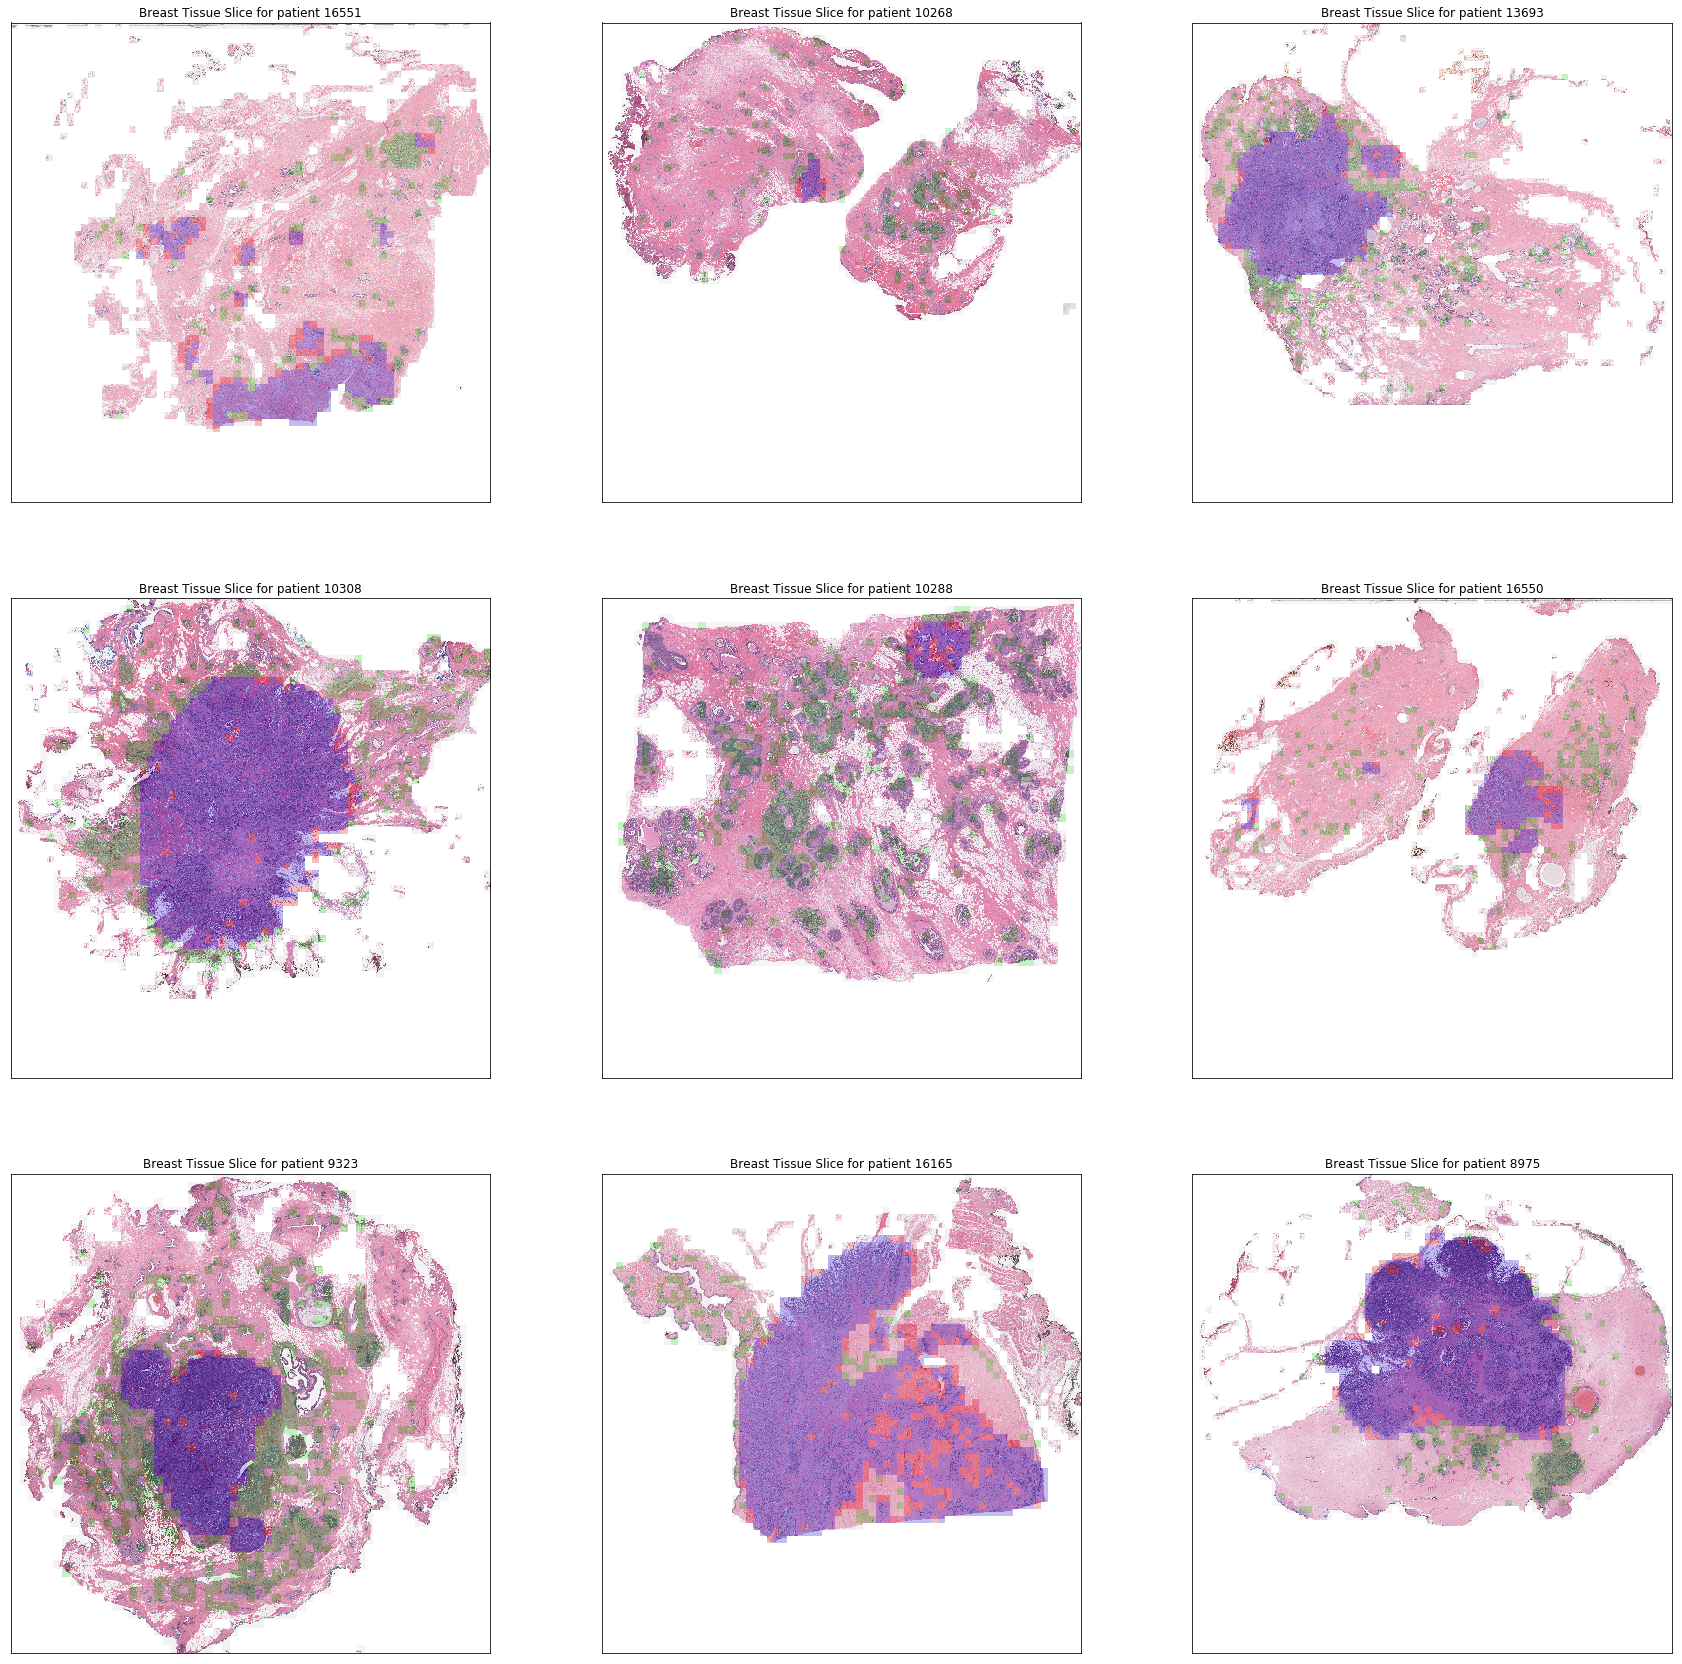

In [178]:
plot_tissue_images_conf(df=sample_df)

add the predicted result to the dataframe

#### Applying PCA on Image Arrays
The PCA function accepts a percentage between 0 and 1, for example n_components = 0.8, would mean return for me the eigen vectors that account for 80% percent of the variation from the in my image arrays.

The PCA function also accepts any number of absolute components that you specify, for example: we initially have 2500 components, if we want the first 150 components then we set n_components = 150.

In [179]:
from sklearn.decomposition import PCA
images_pca = PCA()
# fit the function to our image arrays
images_pca.fit(img_arrays);

ValueError: Found array with dim 4. Estimator expected <= 2.

#### Explaining the Variance Ratio

In [ ]:
# explained get the cumalitive sum of the explained variance ratio for each principle component
evr = np.cumsum(images_pca.explained_variance_ratio_)
# plot the explained variance ratio
fig = go.Figure(data=go.Scatter(y = evr,line=dict(color='#ff70db')))
fig.update_layout(title='Explained Variance Ratio After PCA',
                   xaxis_title='Number of Principle Components',
                   yaxis_title='Cumalitive Explained Variance Ratio')
fig.show()

From the graph above we can determine that the first 150 components account for over 80% percent of the variance in our data. We managed to reduce the number of dimensions of our image arrays from 2500 to 150, while still being able to maintain over 80% of the information, this a 96% reduction in the number of dimensions that we have!

In [ ]:
# let's now apply PCA but only retrieve the first 150 components or the components that account for 80 percent of the variance
images_pca = PCA(0.8)
# OR
images_pca = PCA(150)
# fit the function to our image arrays
images_pca.fit(img_arrays);

#### Initial shape of our image array

In [ ]:
# get the shape of the first image array
sample_df['img_array'][0].shape

In [ ]:
# Apply PCA transformation to each row in the img_array column
# hint: the transform function accepts a list, so if you wanted to feed it one value you would have to place that value in a list
sample_df['pca_array'] = sample_df['img_array'].progress_apply(lambda x: images_pca.transform([x]).flatten()) 

#### Shape of Array after applying PCA

In [ ]:
sample_df['pca_array'][0].shape

In [ ]:
sample_df.head()

### Eigen Patches
If you've hearded eigen faces, this right here is the breast cancer version of that

In [ ]:
# visualizing the first 30 principle components
fig, axes = plt.subplots(3, 10, figsize=(30, 10))
for i, ax in enumerate(axes.flat):
    # return each of the components, and reshape them to 50x50
    ax.imshow(images_pca.components_[i].reshape(50, 50), cmap='binary_r')

### Comparing Images Before & After PCA

Now that we have our eigen vectors, let's compare how our images looked like before PCA and after PCA. What we are about to do is multiply each of one of our components by its corresponding eigen vector and sum it, think of it like a weighted sum.

In [ ]:
components = images_pca.transform(img_arrays)
projected = images_pca.inverse_transform(components)

# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(30, 7))
for i in range(10):
    ax[0, i].imshow(img_arrays[i].reshape(50, 50), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(50, 50), cmap='binary_r')
    
ax[0, 0].set_ylabel('Before PCA')
ax[1, 0].set_ylabel('150-dim\nReconstruction');

# Training - Testing Split

In order to verify our model's performance we need to split our data to testing and training data.
The testing data will verify that our model is able to classify cases that it hasn't seen before. 

Normally, this step would be done before performing PCA, as the testing data would influence our PCA fit. But I will split it here for simplicities sake.

In [ ]:
# get the count of each of the target values
sample_df['target'].value_counts() 

## Training & Testing Split

There are a few things that we must consider before splitting our data. The first being the ratio of cancerous to non cancerous images that we have. We determined earlier that our data is not split uniformly. We have many more, non-cancerous images that non-cancerous images, which may possibly bias our model. 

This may also pose a problem when evaluating our model. Let's take an extreme example where we have a dataset consisting of 100 points, 90 of them are cancerous and 10 of them are non-cancerous, let's also assume that our model classified our entire dataset as cancerous, this would give an accuracy of 90%, however this is not really representitive of what is really happening. In reality it is always misclassifying our non-cancerous data.

So how do we go about solving this?

We can use the train-test split function offered in sklearn model_selection, this function has the option to split our data such that we get equally distributed training and testing sets when grouped by the classes.

For more information, check out this [article](https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36), that talks about the considerations that need to be taken before splitting your data.

### Undersampling Our Data

In our case we will be undersampling our Non-Cancerous Data, in order to make our target distribution more balanced. Ideally we would artificially oversample our data by rotating our cancerous images.

In [ ]:
# get the dataframe containing the negative target variables
negative = sample_df[sample_df['target'] == 0]
# get the dataframe containing the positive target variables
positive = sample_df[sample_df['target'] == 1]
# get the shapes of each dataframe
display(negative.shape)
display(positive.shape)

In order to randomly resample our data we will be using the sklearns.utils function resample. For a more in depth explanation about the parameters of resample, check out the documentation.

In [ ]:
from sklearn.utils import resample
# downsample the negative targets
neg_downsampled = resample(negative,n_samples=positive.shape[0], random_state=42)
# combine minority and downsampled majority
downsampled = pd.concat([positive, neg_downsampled])
# check new class counts
downsampled['target'].value_counts()

In [ ]:
# show the first 5 values of the dataframe
downsampled.head()

In [ ]:
# let's extract our variables of interest and store them in a new dataframe
dfd = downsampled.loc[:,['img_array','pca_array','target']]

In [ ]:
dfd.head()

### Splitting our Data

* ***Training Data*** : Data that we will use to train our model
* ***Testing Data*** : Data that we will use to test our model
* ***Out of Sample Data*** : Data that we will use to further validate our testing. Usually this is taken before preprocessing the data.

We will be using sklearn's train_test_split to split our data. 

Shuffle is set to False, this is because we already manually shuffled our data in the previous cell. 

For simplicity's sake we will not be considering the Out of Sample data, and we will only be splitting our data to training and testing sets.

#### Extracting Data into Array

In [ ]:
# get the number of rows in the pandas dataframe in order to determine the number of rows in our numpy array
nrows=dfd.shape[0]
# set the number of columns to 150, which is the length of our array
ncols=150
# initialize the array using the information above
pca_arrays= np.zeros((nrows,ncols))
print(pca_arrays.shape)

In [ ]:
# loop over the array and replace the data
for i,array in enumerate(dfd['pca_array']):
    pca_arrays[i,:] = array

#### Split the Data

In [ ]:
from sklearn.model_selection import train_test_split
# split our data into training and testing data, and input data and target data
X_train, X_test, y_train, y_test =  train_test_split(pca_arrays, dfd['target'], train_size=0.7, shuffle = True)

In [ ]:
# compare the shape of the train and test inputs
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

# Training Model

### Setting model parameters

In [ ]:
from sklearn.svm import SVC
svc_rbf = SVC(kernel = 'rbf',gamma = 'auto' )
svc_linear = SVC(kernel='linear',gamma = 'auto')

### Fitting the model 

In [ ]:
# fitting our models
svc_rbf.fit(X = X_train,y = y_train);
svc_linear.fit(X = X_train,y = y_train);

### Model Evaluation

Finally we have reached the part to evaluate how well our model does. First let's check out our score on the data that we trained our models on. The cell below retrieves the accuracy for each of our models. Recall that Accuracy is: total correctly classified / total number of classifications.

In [ ]:
print(svc_linear.score(X_train,y_train))
print(svc_rbf.score(X_train,y_train))

Not bad for a first try, and not bad considering the amount of data that we used. However, this is accuracy was tested on the same data that our model was initially trained on. So our model has already seen this data before. 

The real question is: how well does our model do on data that it has not seen before? 

That's what the training data is for...

In [ ]:
print(svc_linear.score(X_test,y_test))
print(svc_rbf.score(X_test,y_test))

#### Confusion Matrix
But Accuracy alone is not a good metric to use and does not reflect the entire picture. 

For that we will be using something known as the confusion matrix. The confusion matrix gives us the following results:

True Postives: When a patch is cancerous and our model correctly classifies it as cancerous<br>
True Negatives: When a patch is not cancerous and our model correctly classifies it as non-cancerous<br>
False Positives: When a patch is non-cancerous but it is misslasified as cancerous <br>
False Negatives: When a patch is cancerous but it is missclasified as non-cancerous

When modeling cancer classification, we need to consider which of the above is more detrimental to the patient.

Is it worse not having cancer and to be classified as having cancer? Or, is it worse having cancer and being told that you do not?

The latter case is much worse, as it will eventually lead to the death of the patient due to not being treated in the first place. 


Based on the above analogy, we would like to maximize the number of times that a paitient suffering from cancer is classified as such, and we would also like to minimize the amount of times that a patient sufferning from cancer is missclassified as not having cancer. 

In other words, we are trying to maximize the True Positives, and Minimize the False Negatives, on the expense of sometimes incorrectly classifying a patient that does not suffer from cancer as cancerous.

In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=svc_linear.predict(X_test)).ravel()

print(f'training set: true negatives: {tn}')
print(f'training set: true positives: {tp}')
print(f'training set: false negatives: {fn}')
print(f'training set: false positives: {fp}')

In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=svc_rbf.predict(X_test)).ravel()

print(f'training set: true negatives: {tn}')
print(f'training set: true positives: {tp}')
print(f'training set: false negatives: {fn}')
print(f'training set: false positives: {fp}')

### Visualizing our Confusion Matrix

The next steps to this model would be to replot the restitched patches from above, and correctly mask them with the right color depending on how they were classified. 

The below function acts similar to a confusion matrix, however it returns numerical values for each input.
*         0 False Negative
*         1 True  Negative
*         3 True  Positive
*         4 False Positive

This is done by getting the predicted value, which is either 0 or 1, and then adding 1 to the value and the squaring it then subtracting it from the actual value. This is done so that we can distinguish the individual cases from each other.

In [ ]:
def confusion_vectors(predicted,actual):
    '''
    Function returns:
        # 0 False Negative
        # 1 True  Negative
        # 3 True  Positive
        # 4 False Positive
    '''
    # get the predicted values
    evaluation = (predicted + 1)**2 - actual
    return evaluation

Let's add the predicted values to our dataframe so that we can compare them with our actual target values. 

In [ ]:
# predict the values for each row, make sure to reshape since predict accepts a 2d vector 
# use [0] to return the first value since predict returns an array, and we are only predicting one row at a time
sample_df['predicted']=sample_df['pca_array'].progress_apply(lambda x: svc_rbf.predict(x.reshape(1,150))[0])

Now that we have the predicted values, we apply the confusion vector function that we created to each of the rows so that we can determine what type of error we got for each prediction.

In [ ]:
# get the confusion vector values for each row, so that we can distinguish what type of error we got for each patch prediction
sample_df['conf']=sample_df.progress_apply(lambda x: confusion_vectors(predicted=x['predicted'],actual=x['target']),axis=1)

In [ ]:
sample_df.head()

Let's try and visualize how are function is doing by restitching the patches together for each patient.

In [ ]:
def get_tissue_image_array_conf(patient_id,path_df):
    # get patient dataframe
    p_df = get_patient_df(patient_id,df=path_df)
    # get the max_coordinate to define the numpy array size, numpy array will be containing the rgb values for the image
    max_coord = np.max((*p_df['x_coord'],*p_df['y_coord']))
    # add 50 to the max_coord to get the final image dimension,50 here is the patch size
    image_dimension = max_coord + 50
    # create a 3 dimensional array with RGB values = 255, we set the type as uint since no RGB value can be > 255, thus increasing efficiency
    grid = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    # initialize empty array for for the mask
    mask = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    # create a dict containing the values to be filled in for each corresponding case
    # 0 is false negative, 3 is true positive, 4 is false positive
    mask_color = {0:[255,0,0],3:[0,0,255],4:[0,255,0]}

    for x,y,conf,path in p_df[['x_coord','y_coord','conf','path']].values:
        img_array = io.imread(path)
#        img_array = cv2.imread(path)
        # some patches have dimension less than 50 x 50 which would cause the code to break
        try:
            # replace values in grid array by the image array values
            grid[y:y+50,x:x+50] = img_array 
            # check if conf is not a true negative
            if conf != 1:
                mask[y:y+50,x:x+50] = mask_color[conf]
        except: pass

    alpha = 0.8
    # This is step is very important, multiplying the 2 values by a float value converts the arrays to float64, which is why convert them back to uint8
    img  = (mask * (1.0 - alpha) + grid * alpha).astype('uint8')
    
    return img

In [ ]:
def plot_tissue_images_conf(nrows=3,ncols=3,df=df):
    n_imgs = nrows*ncols
    p_ids = np.random.choice(df['patient_id'].unique(), size=n_imgs, replace=False)
    
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,30))
    for i,row in enumerate(axs):
        for j,ax in enumerate(row):
            p_id = p_ids[i*nrows+j]
            img = get_tissue_image_array_conf(p_id,path_df=df)
            ax.set_title(f'Breast Tissue Slice for patient {p_id}')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img)

Finally below we replot our patches, this time we use mask colors to indicate the following:
* Green Mask: False Positives
* Blue Mask: True Positives
* Red Mask: False Negatives

In [ ]:
plot_tissue_images_conf(df=sample_df)

From the images above we can conclude that our model is biased towards false positives. Now there are many reasons as to why that may be. 

We can start by filtering by our images by the different confusion matrix cases and we can try to understand what is going on. But I leave that to you. 


I hope this notebook, gave you an idea of what happens behind the scenes of image classification using machine learning, there are still many ways we can improve it, such as using different image kernels to extract features, but that is a task for another day.